In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')

In [3]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/status', 'std_msgs/String'],
 ['/dvrk/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamp

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


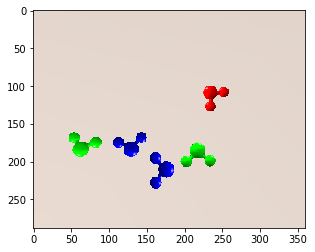

In [5]:
plt.imshow(left_image)

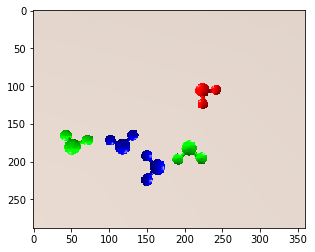

In [6]:
plt.imshow(right_image)

In [7]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 28274
  stamp: 
    secs: 1590122418
    nsecs: 206071854
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 28274
  stamp: 
    secs: 1590122418
    nsecs: 206071854
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0


In [8]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    suj = dvrk.suj('ECM')


In [9]:
psm1.get_current_position()

[[           1,-8.86787e-06,  7.3459e-06;
  1.14775e-05,     0.81921,   -0.573493;
 -9.32174e-07,    0.573493,     0.81921]
[     1.95011,   -0.221842,   -0.844625]]

In [10]:
ecm.get_current_position()

[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[           0,           0,           0]]

In [11]:
suj.get_current_position()

[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[           0,           0,           0]]

In [12]:
tf_listener = tf.TransformListener()

In [13]:
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


[]

[INFO] [1590122420.011226]: Number of feature files:
[INFO] [1590122420.039407]: 1
[INFO] [1590122420.065947]: Feature ranges: 
[INFO] [1590122420.074415]: [[[  0.  37.  45.]
  [ 23. 100. 100.]]]
[INFO] [1590122420.111546]: 0
[INFO] [1590122420.113853]: Size: 51.73973328110612
[INFO] [1590122420.117817]: Height: 288 Width: 360
[INFO] [1590122420.124616]: [x: 241.0
y: 116.0]
[INFO] [1590122420.130267]: [[241. 116.]]
[INFO] [1590122420.132752]: Size: 0.0
[INFO] [1590122420.135117]: Height: 288 Width: 360
[INFO] [1590122420.140890]: [x: 231.0
y: 113.0]
[INFO] [1590122420.142693]: [[231. 113.]]
[INFO] [1590122420.144815]: Size: 0.0
type: 
  data: "centroids"
center: 
  x: 241
  y: 116
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 241.0
    y: 116.0


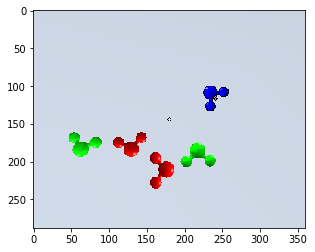

In [14]:
import image_geometry
import vision_pipeline
BALL_FEAT_PATH = '../autonomous_surgical_camera/auto_cam/config/features/red_ball.csv'
cv2.imwrite('left.png', left_image)
fp = vision_pipeline.feature_processor([BALL_FEAT_PATH], 'left.png')
left_feats, left_frame = fp.Centroids(left_image_msg)
right_feats, right_frame = fp.Centroids(right_image_msg)
print(left_feats)
plt.imshow(left_frame)

type: 
  data: "centroids"
center: 
  x: 231
  y: 113
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 231.0
    y: 113.0


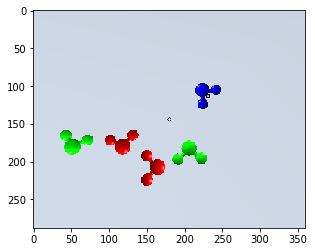

In [15]:
print(right_feats)
plt.imshow(right_frame)

[(241.0, 116.0)]
[(231.0, 113.0)]


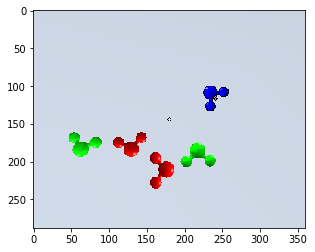

In [16]:
left_cam = image_geometry.PinholeCameraModel()
left_cam.fromCameraInfo(left_camera_info)
right_cam = image_geometry.PinholeCameraModel()
right_cam.fromCameraInfo(right_camera_info)
left_frame_rectified = deepcopy(left_frame)

def rectify(cam, ros_pt):
    return tuple(cam.rectifyPoint((ros_pt.x, ros_pt.y)))

def invert_rectify(cam, ros_pt, frame_dims):
    return tuple(cam.rectifyPoint((frame_dims[0] - ros_pt.x, frame_dims[1] - ros_pt.y)))

left_feat_pts = [(pt.x, pt.y) for pt in left_feats.points]
right_feat_pts = [(pt.x, pt.y)for pt in right_feats.points]
print(left_feat_pts)
print(right_feat_pts)
left_cam.rectifyImage(left_frame, left_frame_rectified)
plt.imshow(left_frame)

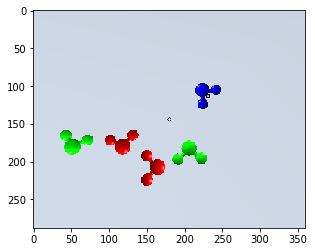

In [17]:
right_frame_rectified = deepcopy(right_frame)
left_cam.rectifyImage(right_frame, right_frame_rectified)
plt.imshow(right_frame_rectified)

In [18]:
from visualization_msgs.msg import Marker
from geometry_msgs.msg import Point
marker_pub = rospy.Publisher('/visualization_marker', Marker, queue_size=10000)

In [19]:
def publish_marker(point, frame, marker_id):
    marker = Marker()
    marker.header.frame_id = frame
    marker.header.stamp = rospy.Time.now()
    marker.type = Marker.SPHERE
    marker.action = Marker.ADD
    marker.id = marker_id
    marker.pose.position.x = point.x()
    marker.pose.position.y = point.y()
    marker.pose.position.z = point.z()
    marker.pose.orientation.x = 0.0
    marker.pose.orientation.y = 0.0
    marker.pose.orientation.z = 0.0
    marker.pose.orientation.w = 1.0
    marker.scale.x = 0.2
    marker.scale.y = 0.2
    marker.scale.z = 0.2
    marker.color.a = 1.0
    marker.color.r = 1.0
    marker.color.g = 0.0
    marker.color.b = 0.0
    marker.lifetime = rospy.Time.from_sec(10000)
    marker_pub.publish(marker)

In [20]:
stereocam = image_geometry.StereoCameraModel()
stereocam.fromCameraInfo(left_camera_info, right_camera_info)
disparity = abs(left_feat_pts[0][0] - right_feat_pts[0][0])
print(disparity)
ball_pos_cam = stereocam.projectPixelTo3d(left_feat_pts[0], disparity)
# opencv coordinates are left handed and ROS coordinates are right handed!!!!!!!! WTF
ball_pos_cam = (ball_pos_cam[1], - ball_pos_cam[0], ball_pos_cam[2])
print(ball_pos_cam)

10.0
(-0.014, -0.0305, 0.15598017585329754)


In [21]:
def tfl_to_pykdl_frame(tfl_frame):
    pos, rot_quat = tfl_frame
    pos2 = PyKDL.Vector(*pos)
    rot = PyKDL.Rotation.Quaternion(*rot_quat)
    return PyKDL.Frame(rot, pos2)

In [22]:
ball_pos_cam = PyKDL.Vector(*ball_pos_cam)
print(ball_pos_cam)
publish_marker(PyKDL.Vector(0, 0, 0), 'world', 1)

[      -0.014,     -0.0305,     0.15598]


In [23]:
tf_cam_to_pitch_link = tf_listener.lookupTransform('ecm_pitch_link', 'camera', rospy.Time())
tf_cam_to_pitch_link = tfl_to_pykdl_frame(tf_cam_to_pitch_link)
tf_pitch_link_to_world = tf_listener.lookupTransform('simworld', 'Jp21_ECM', rospy.Time())
tf_pitch_link_to_world = tfl_to_pykdl_frame(tf_pitch_link_to_world)
tf_cam_to_world = tf_pitch_link_to_world * tf_cam_to_pitch_link

# straight up broadcasted the vision sensor frame
tf_cam_to_world = tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time())
tf_cam_to_world = tfl_to_pykdl_frame(tf_cam_to_world)

In [24]:
# there's a hardcoded rotation between J1_PSM1 in sim and PSM1_psm_main
j1_to_main_rot = PyKDL.Rotation(
    PyKDL.Vector(-1,  0,  0),
    PyKDL.Vector( 0,  0, -1),
    PyKDL.Vector( 0, -1,  0)
)
j1_to_main_trans = PyKDL.Vector(0, 0, 0)
j1_to_main_frame = PyKDL.Frame(j1_to_main_rot, j1_to_main_trans)

tf_world_to_psm1_j1 = tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time())
tf_world_to_psm1_j1 = tfl_to_pykdl_frame(tf_world_to_psm1_j1)
tf_world_to_psm1_main = j1_to_main_frame * tf_world_to_psm1_j1
tf_world_to_psm1_main

[[    0.341784,    0.939779,-9.47923e-06;
    -0.939779,    0.341784, 0.000346971;
  0.000329316,-0.000109681,           1]
[    0.655042,    -1.39907,   -0.798299]]

In [25]:
tf_camera_to_psm1 = tf_world_to_psm1_main * tf_cam_to_world
ball_pos_psm1 = tf_camera_to_psm1 * ball_pos_cam
ball_pos_psm1

[    0.128813,   0.0250737,   -0.274112]

In [26]:
ball_pos_world = tf_cam_to_world * ball_pos_cam
ball_pos_world
ball_pos_j1_psm1 = tf_world_to_psm1_j1 * ball_pos_world
print(ball_pos_j1_psm1)


[   -0.128813,    0.274112,  -0.0250737]


In [27]:
ball_pos_psm1_main = tf_world_to_psm1_main * ball_pos_world
print(ball_pos_psm1_main)

[    0.128813,   0.0250737,   -0.274112]


In [28]:
# this is the position piped directly from the sim
# slight inaccuracy compared to `ball_pos_psm1` but numbers are very close
real_ball_pos_psm1_j1 = PyKDL.Vector(-0.1254749298, 0.2540073991, 0.01814687252)
real_ball_pos_psm1_main = j1_to_main_frame * real_ball_pos_psm1_j1
psm1.move(real_ball_pos_psm1_main)
real_ball_pos_psm1_main

[    0.125475,  -0.0181469,   -0.254007]

In [29]:
psm1.move(real_ball_pos_psm1_main)

True

[ERROR] [1590122534.838052]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7efeb1ef5650>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1590122547.725316]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7efeb1e67990>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j